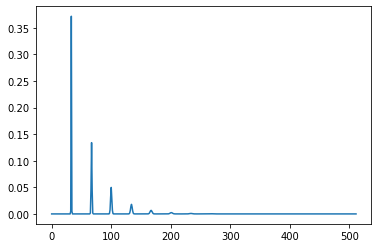

163840
1024


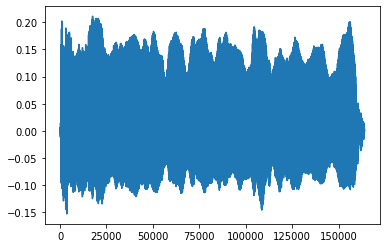

In [87]:
import math
import matplotlib.pyplot as plt
import numpy as np
import librosa

def peakFunction(x):
    """
    Construct a harmonic peak
    """
    return math.exp(-0.5*x*x)

def template(midi, N, sr):
    """
    Returns a frequency spectrum template for the given midi note.
    N must be an even number.
    """
    if N % 2 != 0:
        print("Please crop your recording so that the number of samples is an even number.")
        return None
    f0 = 440*np.power(2, (midi-69)/12) # fundamental frequency
    H = 13 # number of harmonics to include
    bins = math.floor(N/2) # half of the bins
    template = np.zeros(bins) 
    
    for h in range(1, H+1): # h = 1, 2, 3, ..., H
        bin = round(f0*h*N/sr) # bin index of this harmonic
        if bin >= bins: # exceeds Nyquist frequency
            break
        sigma = bin * 0.01 + 0.01 # controls the width of the peak
        for k in range(bins):
            x = (k-bin)/sigma
            template[k] += math.exp(-k*0.03) * peakFunction(x)
    return template

## Print template
plt.plot(template(60, 1024, 8000)) # CHANGE THE FIRST ARGUMENT
plt.show()


## YOUR CODE HERE

x, sr = librosa.load('s1.wav', sr = None)
plt.plot(x)
print(len(x))
x = x[0:1024]
print(len(x))

In [88]:
import numpy as np
import matplotlib.pyplot as plt
#display Spectrogram
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz') 
#If to pring log of frequencies  
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
# Define states
LOW_MIDI = 47
HIGH_MIDI = 74
STATES_PER_NOTE = 5
STATE_VALUES = ((HIGH_MIDI - LOW_MIDI) + 2) * STATES_PER_NOTE # REPLACE IT WITH THE TOTAL NUMBER OF POSSIBLE STATES (INCLUDING "SILENCE")

# Define initial distribution
init_dist = np.zeros(STATE_VALUES)
for i in range(STATE_VALUES):
    if i % STATES_PER_NOTE  == 0: # equal chance of being in the first state of any note
        init_dist[i] = 1/STATE_VALUES

# Define transition matrix
A = np.zeros((STATE_VALUES, STATE_VALUES))
for i in range(A.shape[0]): # for each state
    A[i, i] = 1 # every state has a self loop
    if (i+1)%STATES_PER_NOTE  != 0: # if this state is not the fifth state of a note
        A[i, i+1] = 1 # this state has an arrow to the next state (which is within the same note)
    else: # if this state is the fifth state of a note
        for j in range(STATE_VALUES // STATES_PER_NOTE):
            A[i, j*STATES_PER_NOTE ] = 1

# Normalize every row so each row sums to 1
for i in range(A.shape[0]):
    A[i, ] = A[i, ] / sum(A[i, ])


import math

def peak_fun(x):
    """
    Constructs and returns a harmonic peak
    """
    return math.exp(-0.5*x*x)


def midi2freq(midi):
    """
    Returns the frequency (in Hz) of the given midi number
    """
    return 440*np.power(2, (midi-69)/12)


def template(midi, N, sr):
    """
    Returns a frequency profile template for the given midi note.
        midi: midi number
        N: frame size (must be an even number)
        sr: sample rate
    """
    if N % 2 != 0:
        print("Frame size is not even!")
        return None
    f0 = midi2freq(midi) # fundamental frequency
    H = 13 # maximumn number of harmonics to include
    bins = math.floor(N/2) # half of the DFT result
    template = np.zeros(bins) 
    
    for h in range(1, H+1): # h = 1, 2, 3, ..., H
        bin = round(f0*h*N/sr) # bin index of this harmonic
        if bin >= bins: # exceeds Nyquist frequency
            break
        sigma = bin * 0.01 + 0.01 # controls the width of the peak
        for k in range(bins):
            x = (k-bin)/sigma
            template[k] += math.exp(-k*0.01) * peak_fun(x) # descreasing amplitudes for higher frequencies
    
    for k in range(bins):
        template[k] += 0.002
    # Normalize all bins:
    total = sum(template)
    if (total > 0):
        template = template / total
    else:
        print("The template has 0 everywhere!")
    return template


def create_midi_templates(N, sr):
    """
    Returns a dictionary where the key is a midi number (or 0) and
    the value is the template of this midi note.
    (silence is represented by 0)
    """
    templates = {}
    for midi in range(LOW_MIDI, HIGH_MIDI + 1):
        templates[midi] = template(midi, N, sr)
    # Template for "silence":
    templates[0] = np.repeat(1/math.floor(N/2), math.floor(N/2)) # flat template
    return templates

## YOUR CODE HERE...
created_templates = create_midi_templates(1024, 8000)
# plt.plot(created_templates[56], color="red")
plt.plot(Xdb, color="green")
plt.legend(('56','63'), loc = 'upper right', title = 'MIDI Numbers')
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.title("Frequency Profile Templates for Audio File")
plt.show()
Xdb

print(len(Xdb))
print(len(Xdb[400]))
plt.plot(Xdb[200])

/usr/local/lib/python3.9/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1024
  warnings.warn(


AttributeError: module 'librosa' has no attribute 'display'

<Figure size 1008x360 with 0 Axes>

656


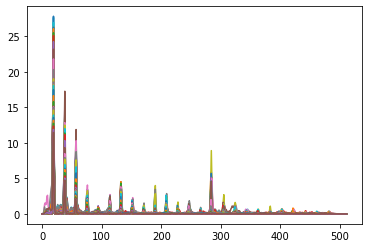

In [162]:
from numpy.fft import fft

SR = 8000 # DON'T CHANGE
N = 1024 # DON'T CHANGE
hop = int(N/2) # DON'T CHANGE
file_path = "dguitarLong.wav"
samples, sr = librosa.load(file_path, sr = SR)

totalHarmonics = []

# print(len(samples))
for x in range(0, int(len(samples) / 1024) - 1):
    realSamples = samples[1026 * x : 1026 * (x + 1)]
    # Calculate STFT
    T = math.floor( (len(realSamples)-N) / hop ) + 1 # the total number of frames
    STFT = np.zeros((N, T), dtype='complex') # the STFT result is a N by T matrix
    hann = 0.5 * ( 1 - np.cos(2*np.pi*np.arange(N)/N) ) # Hann window
    for t in range(T): # for each frame
        chunck = realSamples[t*hop : t*hop + N] # get the frame t of audio data
        X = fft(chunck * hann) # apply FFT on windowed signal (the result contains N complex numbers)
        STFT[:, t] = X
    spect = np.abs(STFT[:int(N/2), :]) # complex numbers --> abs values
    plt.plot(spect[:,0])
    totalHarmonics.append(spect[:,0])
print(len(totalHarmonics))

# Find the midi note
# Convert that to freqeuncy f(Hz)
# k = f * N / sr to find frequency bin
# Find highest value in range of 1 higher to 1 lower frequency bin
# Double f value and recalculate k using new f

In [163]:
# Find the midi note
# Convert that to freqeuncy f(Hz)
# k = f * N / sr to find frequency bin
# Find highest value in range of 1 higher to 1 lower frequency bin
# Double f value and recalculate k using new f
import numpy as np
freq = 146.83
sr = 8000
N = 1024
actualK = (freq * N) / sr
nums = np.array(spect[:,0])
harmonics = []
realHarmonics = []

for spectro in totalHarmonics:
    harmonics = []
    nums = np.array(spectro)
    for i in range(1,6):
        actualK = (i * freq * N) / sr
        val = int(actualK)
        harmonics.append(max(nums[val-10:val+10]))

    sum = 0
    for harmonic in harmonics:
        sum = sum + harmonic

    ratios = []
    for harmonic in harmonics:
        ratios.append(harmonic/sum)

    realHarmonics.append(ratios)

In [161]:
import csv

with open("dGuitarLong.csv","w+") as my_csv:
    csvWriter = csv.writer(my_csv,delimiter=',')
    csvWriter.writerows(realHarmonics)